In [1]:
!pip install requests

In [2]:
!pip install fuzzywuzzy


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import math
import requests
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
%matplotlib inline
#font_manager.fontManager.addfont('C:\\Users\\Doğan Yiğit Yenigün\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Formula1-Regular_web.ttf')

C:\Users\HP\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
season2023RaceCalendar = pd.read_csv('Formula1_2023season_calendar.csv')
season2023RaceCalendar.set_index('Round', inplace=True)
season2023Drivers = pd.read_csv('Formula1_2023season_drivers.csv')
season2023Drivers.set_index('Abbreviation', inplace=True)
season2023Teams = pd.read_csv('Formula1_2023season_teams.csv')
season2023Teams.index = range(1,11)
season2023QualifyingResults = pd.read_csv('Formula1_2023season_qualifyingResults.csv')
season2023SprintShootoutResults = pd.read_csv('Formula1_2023season_sprintShootoutResults.csv')
season2023RaceResults = pd.read_csv('Formula1_2023season_raceResults.csv')
season2023DotdVotes = pd.read_csv('Formula1_2023season_driverOfTheDayVotes.csv')
season2023DotdVotes.set_index('Track', inplace=True)
season2023SprintRace=pd.read_csv('Formula1_2023season_sprintResults.csv')
seasoncircuits=pd.read_csv('circuits.csv')
seasoncircuits.rename(columns={'country': 'Country','location':'City'}, inplace=True)

In [5]:
datasets = {
    'season2023RaceCalendar': season2023RaceCalendar,
    'season2023Drivers': season2023Drivers,
    'season2023Teams': season2023Teams,
    'season2023QualifyingResults': season2023QualifyingResults,
    'season2023SprintRaceResults': season2023SprintShootoutResults,
    'season2023RaceResults': season2023RaceResults,
    'season2023DotdVotes': season2023DotdVotes,
    'season2023SprintRace': season2023SprintRace,
    'seasoncircuits': seasoncircuits
}
for dataset_name, dataset in datasets.items():
    print(f"Dataset: {dataset_name}")
    print(dataset.columns.tolist())
    print()

Dataset: season2023RaceCalendar
['Race Date', 'GP Name', 'Country', 'City', 'Circuit Name', 'First GP', 'Number of Laps', 'Circuit Length(km)', 'Race Distance(km)', 'Lap Record', 'Record Owner', 'Record Year', 'Turns', 'DRS Zones']

Dataset: season2023Drivers
['Driver', 'No', 'Team', 'Country', 'Podiums', 'Points', 'Grands Prix Entered', 'World Championships', 'Highest Race Finish', 'Highest Grid Position', 'Date of Birth', 'Place of Birth']

Dataset: season2023Teams
['Team', 'Full Team Name', 'Base', 'Team Chief', 'Technical Chief', 'Chassis', 'Power Unit', 'First Team Entry', 'World Championships', 'Highest Race Finish', 'Pole Positions', 'Fastest Laps']

Dataset: season2023QualifyingResults
['Track', 'Position', 'No', 'Driver', 'Team', 'Q1', 'Q2', 'Q3', 'Laps']

Dataset: season2023SprintRaceResults
['Track', 'Position', 'No', 'Driver', 'Team', 'SQ1', 'SQ2', 'SQ3', 'Laps']

Dataset: season2023RaceResults
['Track', 'Position', 'No', 'Driver', 'Team', 'Starting Grid', 'Laps', 'Time/Ret

In [6]:
season2023RaceCalendar['Country'].unique()

array(['Bahrain', 'Saudi Arabia', 'Australia', 'Azerbaijan',
       'United States', 'Italy', 'Monaco', 'Spain', 'Canada', 'Austria',
       'Great Britain', 'Hungary', 'Belgium', 'Netherlands', 'Singapore',
       'Japan', 'Qatar', 'Mexico', 'Brazil', 'Abu Dhabi'], dtype=object)

In [7]:
season2023RaceCalendar['City'].unique()

array(['Sakhir', 'Jeddah', 'Melbourne', 'Baku', 'Miami', 'Imola',
       'Monaco', 'Catalunya', 'Montréal', 'Spielberg', 'Silverstone',
       'Budapest', 'Spa-Francorchamps', 'Zandvoort', 'Monza', 'Singapore',
       'Suzuka', 'Lusail', 'Austin', 'Mexico City', 'São Paulo',
       'Las Vegas', 'Yas Island'], dtype=object)

In [8]:
season2023Drivers.index

Index(['VER', 'PER', 'HAM', 'ALO', 'LEC', 'NOR', 'SAI', 'RUS', 'PIA', 'STR',
       'GAS', 'OCO', 'ALB', 'TSU', 'BOT', 'HUL', 'RIC', 'ZHO', 'MAG', 'LAW',
       'SAR', 'DEV'],
      dtype='object', name='Abbreviation')

In [9]:
def assign_color(val_type, values):
    cl = []
    for val in values:
        if val_type == 'drivers':  abbr = val.split()[1].upper()[0:3]
        elif val_type == 'teams':  abbr = val[0:4].upper()
        if abbr in ['ALFA','BOT','ZHO']:           cl.append('#900000')
        elif abbr in ['HAAS','HUL','MAG']:         cl.append('#ffffff')
        elif abbr in ['ASTO','ALO','STR']:   cl.append('#006f62')
        elif abbr in ['WILL','ALB','SAR']:    cl.append('#0072ff')
        elif abbr in ['ALPH','DEV','TSU','RIC']:         cl.append('#2b5962')
        elif abbr in ['MCLA','PIA','NOR']:         cl.append('#ff8700')
        elif abbr in ['RED ','VER','PER']:         cl.append('#0600f0')
        elif abbr in ['FERR','LEC','SAI']:         cl.append('#cb0000')
        elif abbr in ['MERC','HAM','RUS']:         cl.append('#00d2bd')
        elif abbr in ['ALPI','GAS','OCO']:         cl.append('#0090ff')
    return cl

## Data Cleaning

In [10]:
season2023Teams['Team'].isna()

1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: Team, dtype: bool

## Exploring team performance 

The below are the street circults that are in the calenda

In [11]:
street_circuits =['Jeddah','Melbourne','Baku','Miami','Monaco','Singapore','Las Vegas']

### Team Data

In [12]:
racePointsTeam = season2023RaceResults.groupby('Team')['Points'].sum().sort_values(ascending=False)
sprintRacePointsTeam = season2023SprintRace.groupby('Team')['Points'].sum().sort_values(ascending=False)
constructorStandings = (racePointsTeam + sprintRacePointsTeam).fillna(0).sort_values(ascending=False)
constructorStandings = constructorStandings.iloc[:10]
constructorStandings = pd.DataFrame(constructorStandings).reset_index()
constructorStandings['Position'] = range(1,11)
#constructorStandings.set_index('Position', inplace=True)
constructorStandings

,Team,Points,Position
0,Red Bull Racing Honda RBPT,860.0,1
1,Mercedes,409.0,2
2,Ferrari,406.0,3
3,McLaren Mercedes,302.0,4
4,Aston Martin Aramco Mercedes,280.0,5
5,Alpine Renault,120.0,6
6,Williams Mercedes,28.0,7
7,AlphaTauri Honda RBPT,25.0,8
8,Alfa Romeo Ferrari,16.0,9
9,Haas Ferrari,12.0,10


In [17]:
team_name_mapping = {
    'Red Bull Racing Honda RBPT': 'Red Bull Racing',
    'McLaren Mercedes': 'McLaren',
    'Aston Martin Aramco Mercedes': 'Aston Martin',
    'Alpine Renault': 'Alpine',
    'AlphaTauri Honda RBPT': 'AlphaTauri',
    'Williams Mercedes':'Williams',
    'Alfa Romeo Ferrari': 'Alfa Romeo',
    'Haas Ferrari': 'Haas F1 Team'
}

constructorStandings['Team'] = constructorStandings['Team'].replace(team_name_mapping)
Team_powerUnit= pd.merge(constructorStandings,season2023Teams, on='Team',how='left')
Team_powerUnit


,Team,Points,Position,Full Team Name,Base,Team Chief,Technical Chief,Chassis,Power Unit,First Team Entry,World Championships,Highest Race Finish,Pole Positions,Fastest Laps
0,Red Bull Racing,860.0,1,Oracle Red Bull Racing,"Milton Keynes, United Kingdom",Christain Horner,Pierre Waché,RB19,Honda RBPT,1997,6,1(x113),95,95
1,Mercedes,409.0,2,Mercedes-AMG Petronas F1 Team,"Brackley, United Kingdom",Toto Wolff,James Allison,W14,Mercedes,1970,8,1(x116),129,96
2,Ferrari,406.0,3,Scuderia Ferrari,"Maranello, Italy",Frédéric Vasseur,Enrico Cardile / Enrico Gualtieri,SF-23,Ferrari,1950,16,1(x244),249,259
3,McLaren,302.0,4,McLaren Formula 1 Team,"Woking, United Kingdom",Andrea Stella,Peter Prodromou / Neil Houldey,MCL60,Mercedes,1966,8,1(x183),156,165
4,Aston Martin,280.0,5,Aston Martin Aramco Cognizant F1 Team,"Silverstone, United Kingdom",Mike Krack,Dan Fallows,AMR23,Mercedes,2018,0,1(x1),1,1
5,Alpine,120.0,6,BWT Alpine F1 Team,"Enstone, United Kingdom",Bruno Famin,Matt Harman,A523,Renault,1986,2,1(x21),20,15
6,Williams,28.0,7,Williams Racing,"Grove, United Kingdom",James Vowles,Pat Fry,FW45,Mercedes,1978,9,1(x114),128,133
7,AlphaTauri,25.0,8,Scuderia AlphaTauri,"Faenza, Italy",Franz Tost,Jody Egginton,AT04,Honda RBPT,1985,0,1(x2),1,3
8,Alfa Romeo,16.0,9,Alfa Romeo F1 Team Stake,"Hinwil, Switzerland",Alessandro Alunni Bravi,James Key,C43,Ferrari,1993,0,1(x1),1,7
9,Haas F1 Team,12.0,10,MoneyGram Haas F1 Team,"Kannapolis, United States",Guenther Steiner,Simone Resta,VF-23,Ferrari,2016,0,4(x1),1,2


In [19]:
Team_powerUnit.dtypes

Team                    object
Points                 float64
Position                 int64
Full Team Name          object
Base                    object
Team Chief              object
Technical Chief         object
Chassis                 object
Power Unit              object
First Team Entry         int64
World Championships      int64
Highest Race Finish     object
Pole Positions           int64
Fastest Laps             int64
dtype: object

In [25]:
tracks = season2023RaceResults['Track'].unique()
tracksSprint = season2023SprintRace['Track'].unique()
season2023RaceResults['Team'] = season2023RaceResults['Team'].replace(team_name_mapping)
season2023SprintRace['Team'] = season2023SprintRace['Team'].replace(team_name_mapping)

teamNames = constructorStandings['Team'].unique()
teamPoints = {};   teamPointsSprint = {}
trackTeamPtsMerged = season2023RaceResults.groupby(['Track','Team'])['Points'].sum()
trackTeamPtsSprintMerged =  season2023SprintRace.groupby(['Track','Team'])['Points'].sum()
for team in teamNames:
    teamPoints[team] = trackTeamPtsMerged[slice(None), team].reindex(tracks).values
    teamPointsSprint[team] = trackTeamPtsSprintMerged[slice(None), team].reindex(tracksSprint).values
sp = [3, 10, 20]
for team in teamNames:
    for i in range(len(sp)):
        teamPoints[team][sp[i]] = teamPoints[team][sp[i]] + teamPointsSprint[team][i]

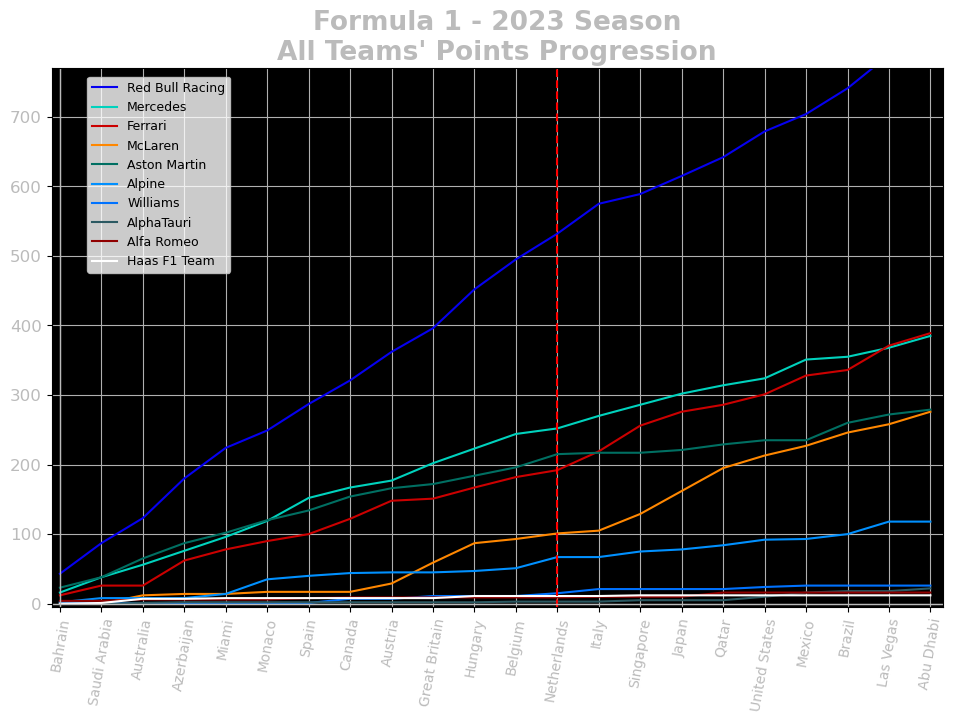

In [31]:
c = assign_color('teams', teamNames)

break_index = 12
plt.figure(figsize=(11.5,7))
plt.axis([-0.2,21.3,-5,770])

for i in range(10):
    plt.plot(teamPoints[teamNames[i]].cumsum(), color=c[i], label=teamNames[i])

plt.gca().set_facecolor('black')
plt.axvline(break_index, color='red', linestyle='--')

plt.title('Formula 1 - 2023 Season\nAll Teams\' Points Progression', fontsize=19, fontweight='bold', color='#bbbbbb')
plt.xticks(range(0,len(tracks)), tracks, rotation=80, fontsize=10, color='#bbbbbb')
plt.yticks(fontsize=12, color='#bbbbbb')
plt.axvline(0, linewidth=1, color='#bbbbbb')
plt.axhline(0, linewidth=1, color='#bbbbbb')
plt.legend(loc=(0.04,0.62), fontsize=9)
plt.grid(True)
plt.show()

From the graph we can see that Redbull had an unbeatable for the first and the second Half. There was a huge improvement in teams like Mclaren and Ferrari after the summer break which showed how the worked on changes to improve their perfomance. From this i can say there might be competition in the 2024 season because they have shown that they have figured out where they had gone wrong and now can fight to the top. For redbull it might be a long way to beat them in this coming season.

In [23]:
season2023RaceResults

,Track,Position,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Set Fastest Lap,Fastest Lap Time
0,Bahrain,1,1,Max Verstappen,Red Bull Racing,1,57,1:33:56.736,25,No,1:36.236
1,Bahrain,2,11,Sergio Perez,Red Bull Racing,2,57,+11.987,18,No,1:36.344
2,Bahrain,3,14,Fernando Alonso,Aston Martin,5,57,+38.637,15,No,1:36.156
3,Bahrain,4,55,Carlos Sainz,Ferrari,4,57,+48.052,12,No,1:37.130
4,Bahrain,5,44,Lewis Hamilton,Mercedes,7,57,+50.977,10,No,1:36.546
...,...,...,...,...,...,...,...,...,...,...,...
435,Abu Dhabi,16,2,Logan Sargeant,Williams,20,58,+87.791,0,No,1:28.580
436,Abu Dhabi,17,24,Guanyu Zhou,Alfa Romeo,19,58,+89.422,0,No,1:28.746
437,Abu Dhabi,18,55,Carlos Sainz,Ferrari,16,57,DNF,0,No,1:29.452
438,Abu Dhabi,19,77,Valtteri Bottas,Alfa Romeo,18,57,+1 lap,0,No,1:29.863


In [38]:
# Merge the season2023RaceResults DataFrame with the season2023Teams DataFrame based on the 'Team' column
merged_results = season2023RaceResults.merge(season2023Teams[['Team', 'Power Unit']], on='Team', how='left')

# Select only the 'Track', 'Position', 'No', 'Driver', 'Team', 'Starting Grid', 'Laps', 'Time/Retired', 'Points', 'Set Fastest Lap', 'Fastest Lap Time', and 'Power Unit' columns
result_with_power_unit = merged_results[['Track', 'No', 'Driver', 'Team', 'Starting Grid', 'Laps', 'Time/Retired', 'Points', 'Set Fastest Lap', 'Fastest Lap Time', 'Power Unit']]


result_with_power_unit

,Track,No,Driver,Team,Starting Grid,Laps,Time/Retired,Points,Set Fastest Lap,Fastest Lap Time,Power Unit
0,Bahrain,1,Max Verstappen,Red Bull Racing,1,57,1:33:56.736,25,No,1:36.236,Honda RBPT
1,Bahrain,11,Sergio Perez,Red Bull Racing,2,57,+11.987,18,No,1:36.344,Honda RBPT
2,Bahrain,14,Fernando Alonso,Aston Martin,5,57,+38.637,15,No,1:36.156,Mercedes
3,Bahrain,55,Carlos Sainz,Ferrari,4,57,+48.052,12,No,1:37.130,Ferrari
4,Bahrain,44,Lewis Hamilton,Mercedes,7,57,+50.977,10,No,1:36.546,Mercedes
...,...,...,...,...,...,...,...,...,...,...,...
435,Abu Dhabi,2,Logan Sargeant,Williams,20,58,+87.791,0,No,1:28.580,Mercedes
436,Abu Dhabi,24,Guanyu Zhou,Alfa Romeo,19,58,+89.422,0,No,1:28.746,Ferrari
437,Abu Dhabi,55,Carlos Sainz,Ferrari,16,57,DNF,0,No,1:29.452,Ferrari
438,Abu Dhabi,77,Valtteri Bottas,Alfa Romeo,18,57,+1 lap,0,No,1:29.863,Ferrari


Checking the which power unit had the most top 10 finish in all the races and which had the most DNF. To some extend it could be a bias because the number of mercedes power unit on the grid is many

In [37]:

top_10_counts = result_with_power_unit[result_with_power_unit['Points'] > 0]['Power Unit'].value_counts()

dnf_counts = result_with_power_unit[result_with_power_unit['Time/Retired'].str.contains('DNF')]['Power Unit'].value_counts()

most_top_10 = top_10_counts.idxmax()
most_top_10_count = top_10_counts.max()

least_dnf = dnf_counts.idxmin()
least_dnf_count = dnf_counts.min()

print("Power unit with the most top 10 finishes:", most_top_10)
print("Number of top 10 finishes:", most_top_10_count)
print("Power unit with the least DNFs:", least_dnf)
print("Number of DNFs:", least_dnf_count)



Power unit with the most top 10 finishes: Mercedes
Number of top 10 finishes: 103
Power unit with the least DNFs: Honda RBPT
Number of DNFs: 6


##### Checking the ponts gain street races v Non street race

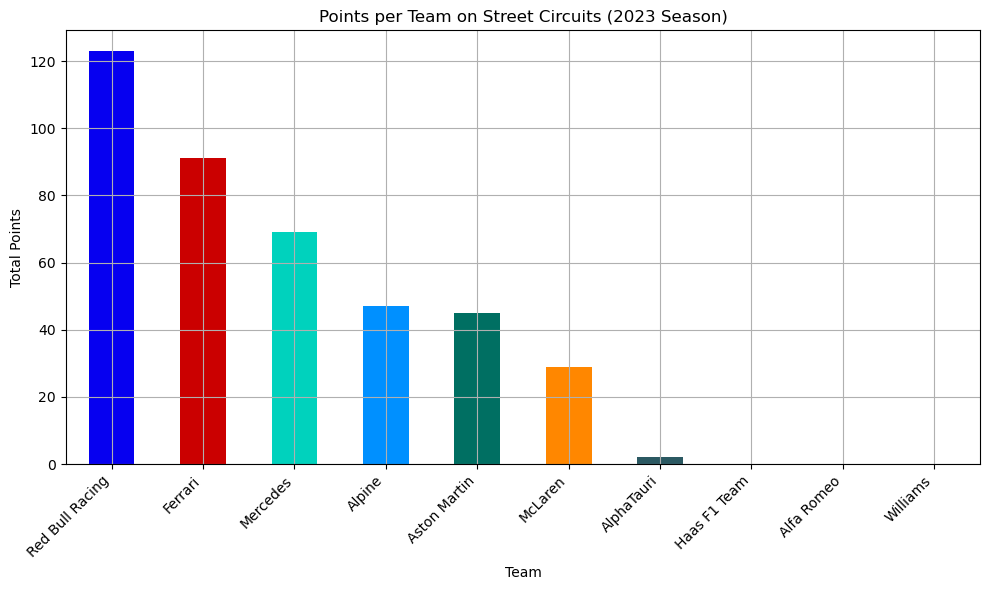

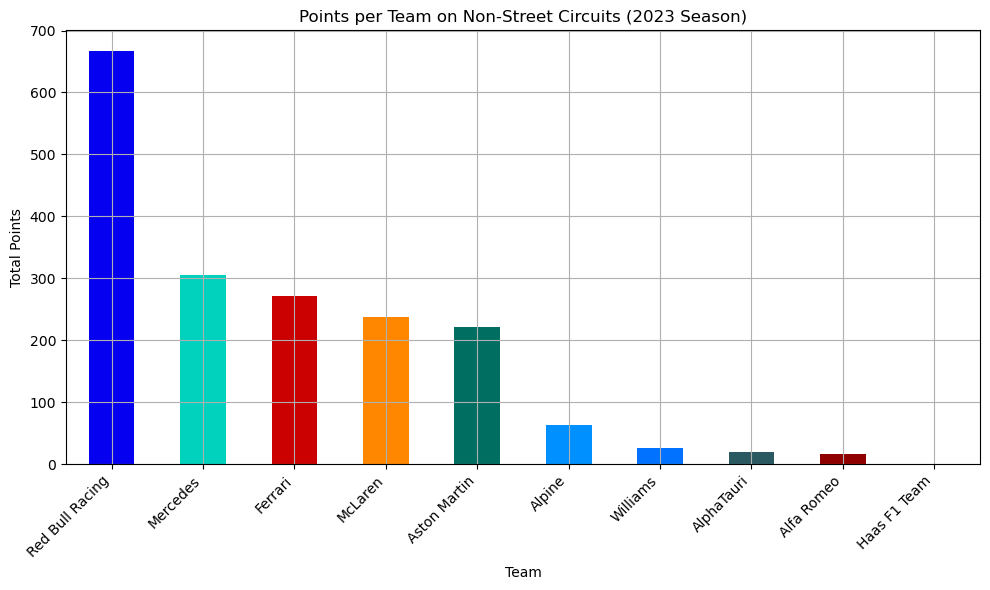

In [60]:
team_color=('teams',street_points.index)

# Filter race results to include only street circuits
street_circuits = ['Jeddah', 'Melbourne', 'Baku', 'Miami', 'Monaco', 'Singapore', 'Las Vegas']
street_results = season2023RaceResults[season2023RaceResults['Track'].isin(street_circuits)]
street_points = street_results.groupby('Team')['Points'].sum().sort_values(ascending=False)


c = assign_color('teams', street_points.index)
plt.figure(figsize=(10, 6))
street_points.plot(kind='bar', color=c)
plt.title('Points per Team on Street Circuits (2023 Season)')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

non_street_results = season2023RaceResults[~season2023RaceResults['Track'].isin(street_circuits)]
non_street_points = non_street_results.groupby('Team')['Points'].sum().sort_values(ascending=False)


c_non_street = assign_color('teams', non_street_points.index)

plt.figure(figsize=(10, 6))
non_street_points.plot(kind='bar', color=c_non_street)
plt.title('Points per Team on Non-Street Circuits (2023 Season)')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


So i was inverstigating to see which team had the most points in street race compared to the other. Mercedes comparing to Ferrari had good runs in non street races as compared to Ferrari. This could because of good  strategies of the ferrari or the street races suited the Ferrari care more than the Mercedes. On also another not we can see Alpine having the best also in street races compared to its competitors which are Mclaren and Astone Martin but Mclaren doing the most in non street races.Lastly we see that teams like Haas F1, Alpha Romeo and Williams not having any points in street race which is something they will have to look into.